In [1]:
import fceulib
import ppu_dump
import sys
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from fceu_help import pointer_to_numpy

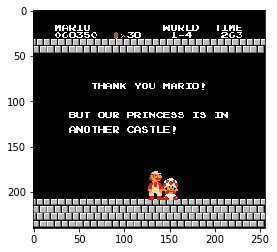

In [138]:
rom = "mario.nes"

movie = 'happylee4-smb-warpless.fm2'

#movie = "mario.fm2"
# start_t = 373
# rom = "metroid.nes"
# movie = "metroid.fm2"
# start_t = 518+39
#rom = "metroid.nes"
#movie ='lordtom-metroid-100.fm2'
#movie = "metroid-long.fm2"

#rom = 'zelda.nes'
#movie = 'baxter,jprofit22-legendofzelda.fm2'
#movie = 'zelda.fm2'
start_t = 7800


# rom = "smb2u.nes"
# movie = "smb2u.fm2"
# start_t = 700
emu = fceulib.runGame(rom)
inputs1 = fceulib.readInputs(movie)
inputs2 = fceulib.readInputs2(movie)

for i,i2 in zip(inputs1[:start_t],inputs2[:start_t]):
    emu.stepFull(i, i2)
    
 
def convert_image(img_buffer):
    # TODO: without allocations/reshape?
    screen = pointer_to_numpy(img_buffer)
    return screen.reshape([256, 256, 4])[:240, :, :3].astype(np.uint8)
img_buffer = fceulib.VectorBytes()
np_image = np.zeros(shape=(240, 256, 1), dtype=np.uint8)
emu.imageInto(img_buffer)
np_image = convert_image(img_buffer)
plt.imshow(np_image)
plt.show()


    

NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
T: 0


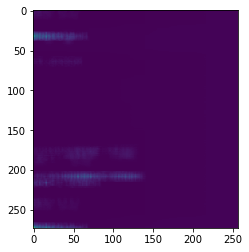

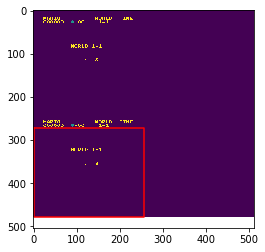

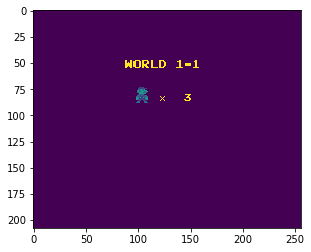

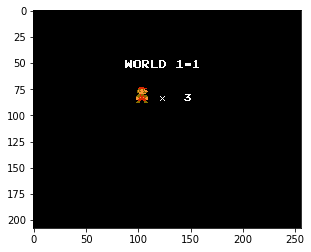

0 34 0 34 (0, 0)
Match1 -0.00753257889301 0.999999821186 (20, 16) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 34 (0, 0)
Match1 -0.00753257889301 0.999999821186 (20, 16) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 34 (0, 0)
Match1 -0.00753257889301 0.999999821186 (20, 16) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 34 (0, 0)
Match1 -0.00753257889301 0.999999821186 (20, 16) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 34 (0, 0)
Match1 -0.00753257889301 0.999999821186 (20, 16) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 34 (0, 0)
Match1 -0.00753257889301 0.999999821186 (20, 16) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 34 (0, 0)
Match1 -0.00753257889301 0.999999821186 (20, 16) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 34 (0, 0)
Match1 -0.00753257889301 0.999999821186 (20, 16) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2

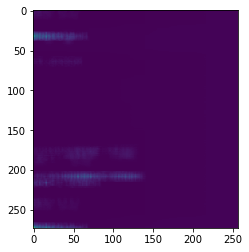

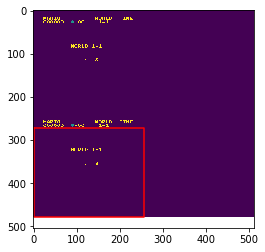

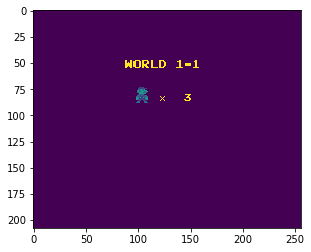

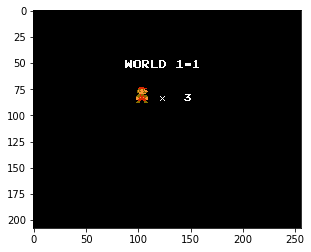

0 34 0 34 (0, 0)
Match1 -0.00753257889301 0.999999821186 (20, 16) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 34 (0, 0)
Match1 -0.00753257889301 0.999999821186 (20, 16) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 34 (0, 0)
Match1 -0.00753257889301 0.999999821186 (20, 16) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 34 (0, 0)
Match1 -0.00753257889301 0.999999821186 (20, 16) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 34 (0, 0)
Match1 -0.00753257889301 0.999999821186 (20, 16) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 34 (0, 0)
Match1 -0.00753257889301 0.999999821186 (20, 16) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 34 (0, 0)
Match1 -0.00753257889301 0.999999821186 (20, 16) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 34 (0, 0)
Match1 -0.00753257889301 0.999999821186 (20, 16) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2

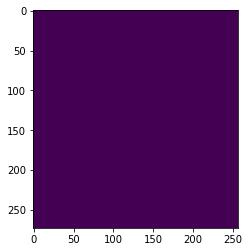

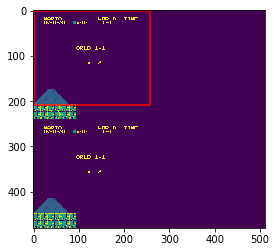

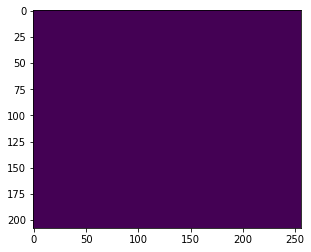

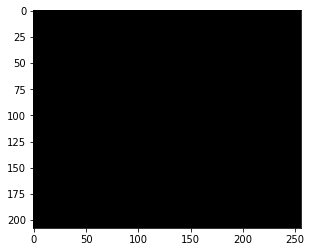

0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match

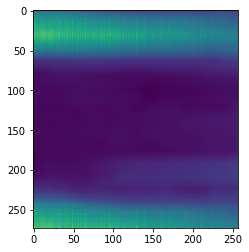

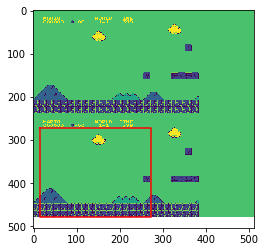

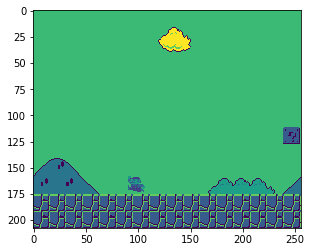

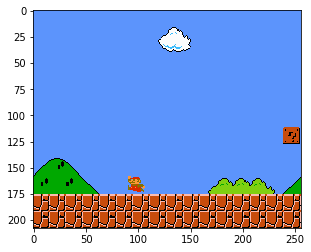

2 34 1 4 (1, 0)
Match1 0.484939008951 0.987332999706 (24, 0) (9, 8)
Sc1 Offset: 1 0 18 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 2 34
2 34 2 34 (0, 0)
Match1 0.491170197725 0.990967273712 (9, 23) (10, 8)
Sc1 Offset: 2 0 20 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 2 4
2 4 2 34 (0, 0)
Match1 0.478916466236 0.992037594318 (24, 0) (9, 8)
Sc1 Offset: 1 0 21 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 2 34
2 34 2 4 (0, 0)
Match1 0.485921323299 0.9883659482 (9, 23) (10, 8)
Sc1 Offset: 2 0 23 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 2 34
2 34 2 34 (0, 0)
Match1 0.476861596107 0.991735160351 (24, 0) (9, 8)
Sc1 Offset: 1 0 24 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 3 4
3 4 2 34 (1, 0)
Match1 0.481340795755 0.990296661854 (9, 23) (10, 8)
Sc1 Offset: 2 0 26 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 3 34
3 34 3 4 (0, 0)
Match1 0.47068631649 0.990761339664 (24, 0) (9, 8)
Sc1 Offset: 1 0 27 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 3 4
3 4 3 34 (0, 0)
Match1 0.47160410881 0.990644931793 (9, 23) (10, 8)
Sc1 Offset: 2 0 29 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 3 4
3 4 3 4 (0

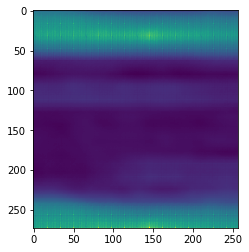

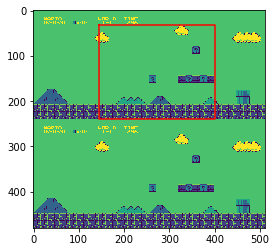

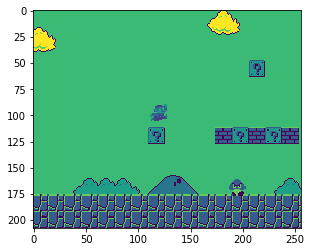

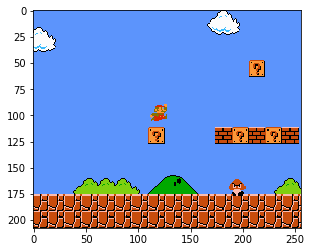

18 4 17 4 (1, 0)
Match1 0.330046981573 0.992431342602 (17, 23) (10, 8)
Sc1 Offset: 2 0 148 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 18 4
18 4 18 4 (0, 0)
Match1 0.327241688967 0.985621392727 (18, 23) (11, 8)
Sc1 Offset: 3 0 151 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 18 4
18 4 18 4 (0, 0)
Match1 0.326110571623 0.991183161736 (17, 23) (10, 8)
Sc1 Offset: 2 0 153 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 19 4
19 4 18 4 (1, 0)
Match1 0.325075238943 0.984370589256 (10, 23) (11, 8)
Sc1 Offset: 3 0 156 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 19 4
19 4 19 4 (0, 0)
Match1 0.322570502758 0.989106714725 (9, 23) (10, 8)
Sc1 Offset: 2 0 158 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 19 34
19 34 19 4 (0, 0)
Match1 0.318851172924 0.982169091702 (10, 23) (11, 8)
Sc1 Offset: 3 0 161 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 20 34
20 34 19 34 (1, 0)
Match1 0.319834828377 0.987656235695 (9, 23) (10, 8)
Sc1 Offset: 2 0 163 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 20 4
20 4 20 34 (0, 0)
Match1 0.320856243372 0.980075061321 (10, 23) (11, 8)
Sc1 Offset: 3 0 166 0
NTS:
0 

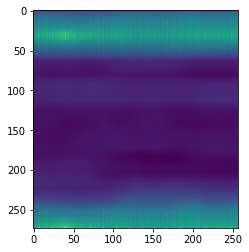

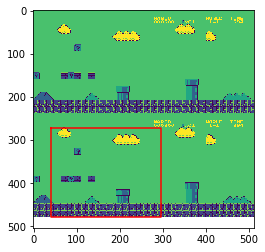

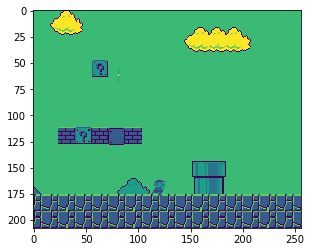

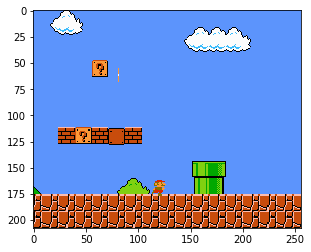

5 34 4 4 (1, 0)
Match1 0.31330126524 0.983267247677 (1, 23) (10, 8)
Sc1 Offset: 2 0 298 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 5 4
5 4 5 34 (0, 0)
Match1 0.305591613054 0.984030723572 (2, 23) (11, 8)
Sc1 Offset: 3 0 301 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 5 4
5 4 5 4 (0, 0)
Match1 0.296425104141 0.986566066742 (1, 23) (10, 8)
Sc1 Offset: 2 0 303 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 5 4
5 4 5 4 (0, 0)
Match1 0.293294101954 0.984716117382 (2, 23) (11, 8)
Sc1 Offset: 3 0 306 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 6 4
6 4 5 4 (1, 0)
Match1 0.289910495281 0.985057115555 (1, 23) (10, 8)
Sc1 Offset: 2 0 308 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 6 4
6 4 6 4 (0, 0)
Match1 0.290674746037 0.985179543495 (2, 23) (11, 8)
Sc1 Offset: 3 0 311 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 6 4
6 4 6 4 (0, 0)
Match1 0.291616886854 0.99080991745 (1, 23) (10, 8)
Sc1 Offset: 2 0 313 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 7 4
7 4 6 4 (1, 0)
Match1 0.295778095722 0.98650932312 (2, 23) (11, 8)
Sc1 Offset: 3 0 316 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 7 4
7 4 7 4 (

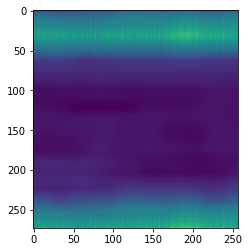

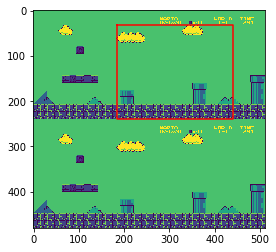

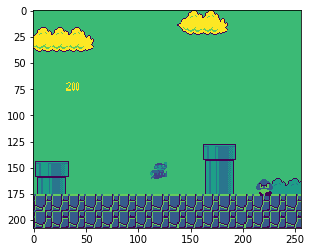

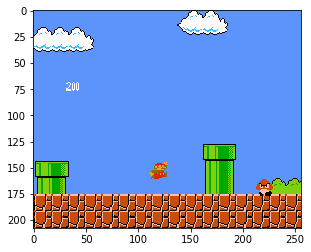

23 4 23 4 (0, 0)
Match1 0.414705425501 0.978587031364 (24, 0) (10, 8)
Sc1 Offset: 2 0 448 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 24 4
24 4 23 4 (1, 0)
Match1 0.416326314211 0.980962157249 (24, 0) (11, 8)
Sc1 Offset: 3 0 451 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 24 4
24 4 24 4 (0, 0)
Match1 0.408451408148 0.977969825268 (24, 0) (10, 8)
Sc1 Offset: 2 0 453 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 24 4
24 4 24 4 (0, 0)
Match1 0.423095226288 0.984390616417 (24, 0) (11, 8)
Sc1 Offset: 3 0 456 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 25 4
25 4 24 4 (1, 0)
Match1 0.421131104231 0.987041532993 (24, 0) (10, 8)
Sc1 Offset: 2 0 458 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 25 4
25 4 25 4 (0, 0)
Match1 0.42974704504 0.987494170666 (24, 0) (11, 8)
Sc1 Offset: 3 0 461 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 25 4
25 4 25 4 (0, 0)
Match1 0.420183748007 0.977202117443 (24, 0) (10, 8)
Sc1 Offset: 2 0 463 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 25 4
25 4 25 4 (0, 0)
Match1 0.422015726566 0.979229152203 (24, 0) (11, 8)
Sc1 Offset: 3 0 466 0
NTS:
1 0 
3 2
M 1 ba

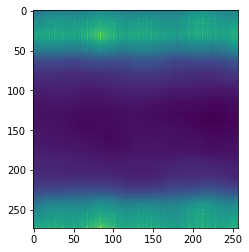

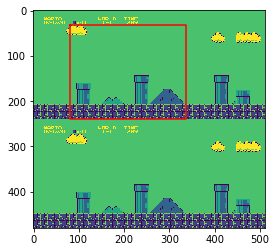

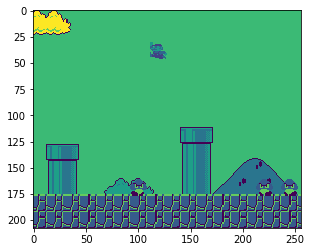

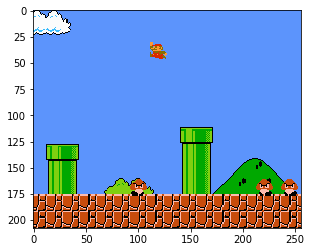

10 4 10 4 (0, 0)
Match1 0.465599775314 0.987222611904 (24, 23) (10, 8)
Sc1 Offset: 2 0 598 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 10 34
10 34 10 4 (0, 0)
Match1 0.478527516127 0.988605856895 (0, 23) (11, 8)
Sc1 Offset: 3 0 601 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 11 4
11 4 10 34 (1, 0)
Match1 0.476872175932 0.98717302084 (24, 23) (10, 8)
Sc1 Offset: 2 0 603 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 11 4
11 4 11 4 (0, 0)
Match1 0.483129620552 0.985652387142 (24, 24) (11, 8)
Sc1 Offset: 3 0 606 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 11 4
11 4 11 4 (0, 0)
Match1 0.473115116358 0.98422652483 (24, 23) (10, 8)
Sc1 Offset: 2 0 608 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 12 34
12 34 11 4 (1, 0)
Match1 0.479474067688 0.986971199512 (24, 24) (11, 8)
Sc1 Offset: 3 0 611 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 12 4
12 4 12 34 (0, 0)
Match1 0.469673186541 0.983742952347 (24, 23) (10, 8)
Sc1 Offset: 2 0 613 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 12 4
12 4 12 4 (0, 0)
Match1 0.477489501238 0.985158205032 (24, 23) (11, 8)
Sc1 Offset: 3 0 616 0
NTS:
0 1

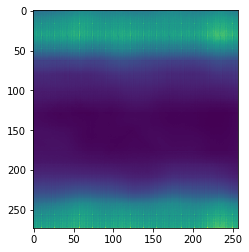

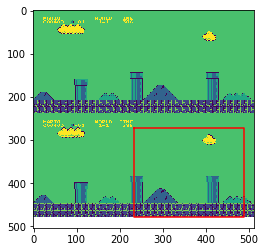

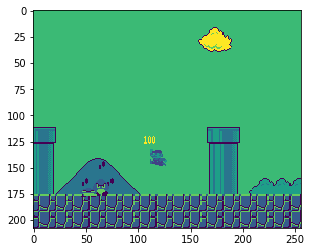

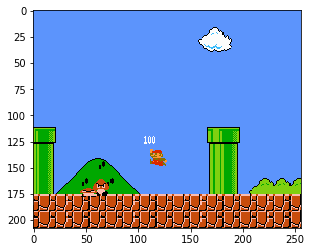

29 34 28 4 (1, 0)
Match1 0.447011530399 0.98161303997 (24, 23) (10, 8)
Sc1 Offset: 2 0 748 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 29 4
29 4 29 34 (0, 0)
Match1 0.458139806986 0.983746767044 (22, 23) (11, 8)
Sc1 Offset: 3 0 751 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 29 4
29 4 29 4 (0, 0)
Match1 0.454496979713 0.981574654579 (24, 23) (10, 8)
Sc1 Offset: 2 0 753 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 4
30 4 29 4 (1, 0)
Match1 0.454099237919 0.981009960175 (0, 23) (11, 8)
Sc1 Offset: 3 0 756 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 4
30 4 30 4 (0, 0)
Match1 0.459148347378 0.98489266634 (1, 23) (10, 8)
Sc1 Offset: 2 0 758 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 30 4
30 4 30 4 (0, 0)
Match1 0.457270532846 0.982082903385 (0, 23) (11, 8)
Sc1 Offset: 3 0 761 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 4
31 4 30 4 (1, 0)
Match1 0.46729055047 0.986762344837 (1, 23) (10, 8)
Sc1 Offset: 2 0 763 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 31 4
31 4 31 4 (0, 0)
Match1 0.467061787844 0.981541752815 (0, 23) (11, 8)
Sc1 Offset: 3 0 766 0
NTS:
0 1 
2 3
M 1

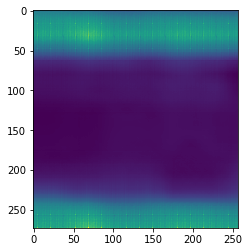

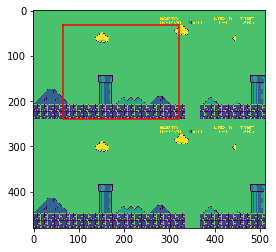

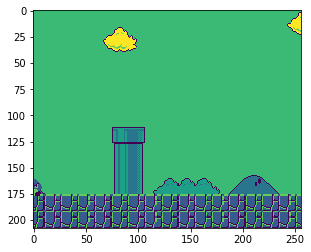

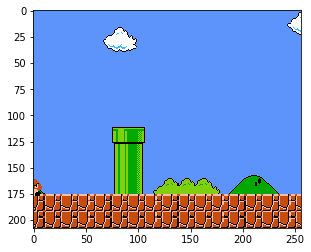

8 4 8 34 (0, 0)
Match1 0.433169186115 1.0 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 8 4
8 4 8 4 (0, 0)
Match1 0.433611422777 0.999432086945 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 8 34
8 34 8 4 (0, 0)
Match1 0.433612406254 0.999999940395 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 8 34
8 34 8 34 (0, 0)
Match1 0.434101074934 0.99934732914 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 8 4
8 4 8 34 (0, 0)
Match1 0.434101074934 0.999999761581 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 8 4
8 4 8 4 (0, 0)
Match1 0.434609860182 0.999212741852 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 8 4
8 4 8 4 (0, 0)
Match1 0.434609860182 0.999999940395 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 8 4
8 4 8 4 (0, 0)
Match1 0.435098528862 0.998642086983 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
1 0 
3 2
M 1 base 1
Sc2: 8 4
8 4 8 4 (0, 0

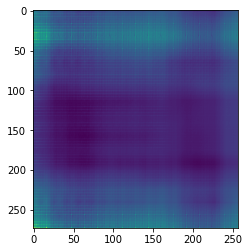

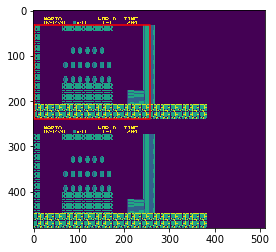

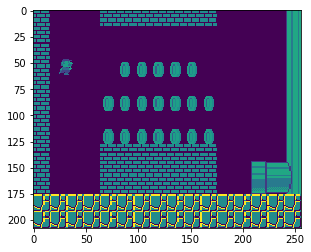

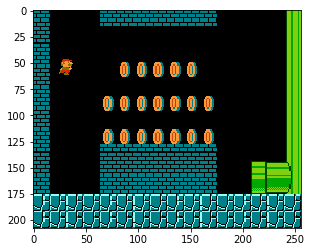

0 4 0 4 (0, 0)
Match1 0.145485952497 0.994418501854 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 4 (0, 0)
Match1 0.16376504302 0.977456092834 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 34 (0, 0)
Match1 0.184742376208 0.993733644485 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.184598252177 0.992375135422 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 4 (0, 0)
Match1 0.184709891677 0.993733644485 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 34 (0, 0)
Match1 0.184802412987 0.992375135422 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 34 (0, 0)
Match1 0.184731706977 0.992375075817 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.184802472591 0.990904450417 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4


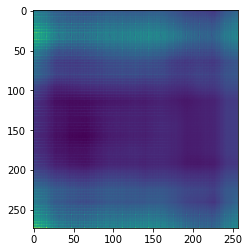

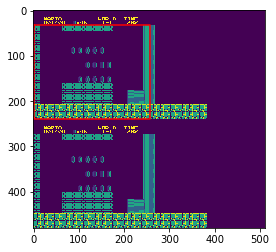

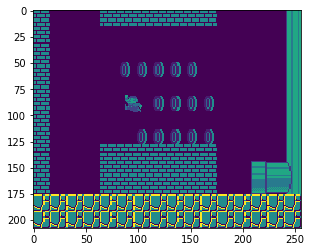

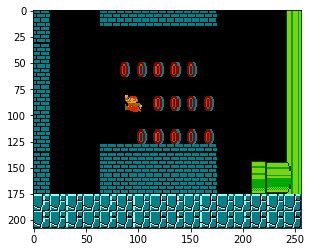

0 4 0 4 (0, 0)
Match1 0.229633063078 0.993354797363 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.229633063078 0.99157589674 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.22983507812 0.99197191 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.230275124311 0.990926921368 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.23321904242 0.987846136093 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.222075298429 0.976510286331 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.212682411075 0.989387631416 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.21431325376 0.981947183609 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
M

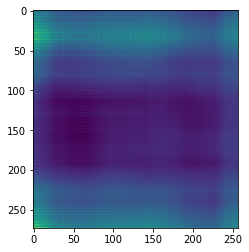

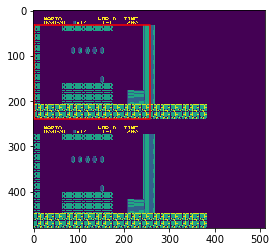

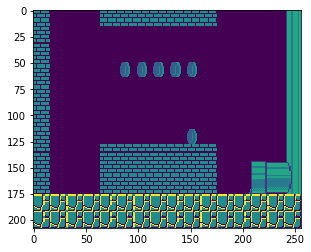

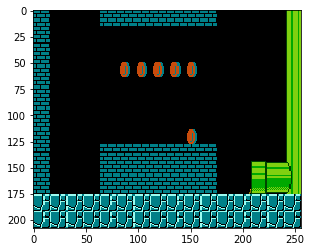

0 4 0 34 (0, 0)
Match1 0.247866988182 1.0 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.237965583801 0.993312239647 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 4 (0, 0)
Match1 0.230416342616 0.998902320862 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 34 (0, 0)
Match1 0.230072781444 0.999289214611 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.230161562562 0.999545574188 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.23029075563 0.999999940395 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.230259820819 0.999630391598 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.230360522866 0.999999940395 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
M

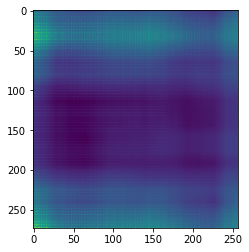

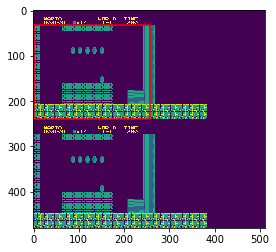

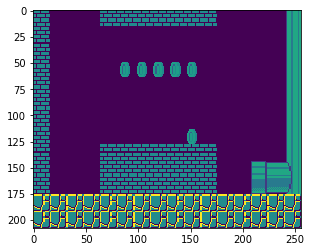

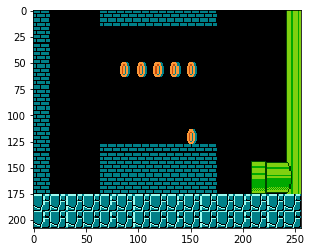

0 4 0 4 (0, 0)
Match1 0.230360522866 0.999999940395 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.230360522866 0.999999940395 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.230360522866 0.999999940395 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.230360522866 0.999999940395 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.230360522866 0.999999940395 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.230360522866 0.999999940395 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.230360522866 0.999999940395 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.230360522866 0.999999940395 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 

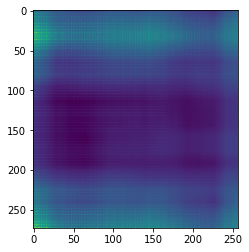

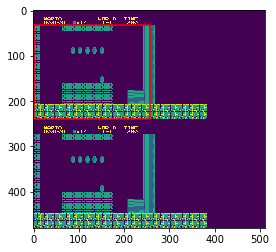

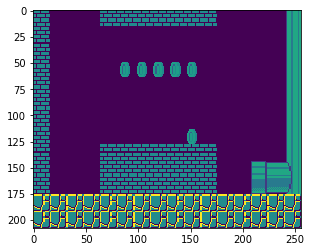

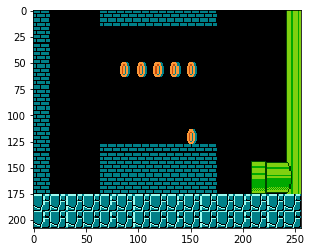

0 4 0 4 (0, 0)
Match1 0.230360522866 0.999999940395 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.240069925785 0.993660986423 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.247918531299 0.999999880791 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.247918531299 0.999999880791 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.247918531299 0.999999880791 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.247918531299 0.999999880791 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.247918531299 0.999999880791 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.247918531299 0.999999880791 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 

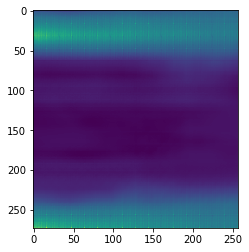

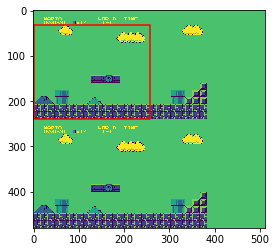

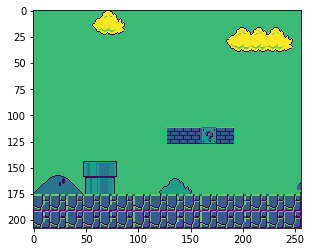

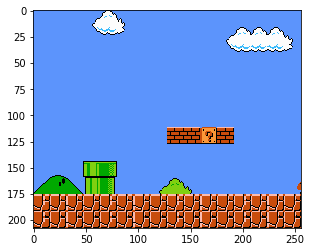

0 4 0 34 (0, 0)
Match1 0.337917506695 1.0 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.337917506695 1.0 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.337594568729 1.0 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.337594568729 1.0 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.337261468172 0.999999463558 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.337261468172 0.999999463558 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.336876869202 0.999999463558 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 4
0 4 0 4 (0, 0)
Match1 0.336876869202 0.999999463558 (23, 23) (8, 8)
Sc1 Offset: 0 0 837 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 34
0 34 0 4 (0, 0)
Match1 0.336230248213 0.9999994635

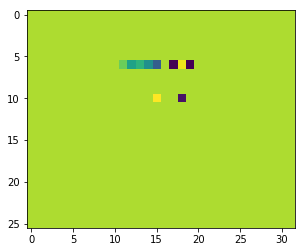

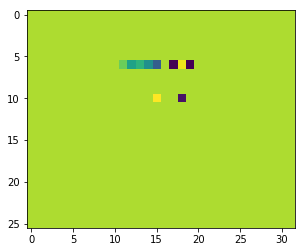

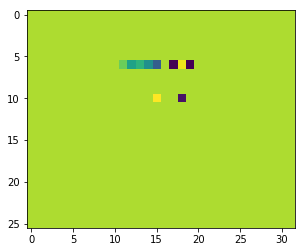

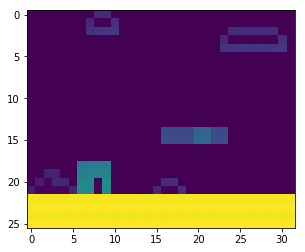

In [3]:
reload(ppu_dump)

end = 5000
#METROID
scroll_area= (0,4,32,30-4)

#ZELDA
#scroll_area= (0,8,32,30-8)

ep_data = ppu_dump.ppu_output(emu,
                              inputs1[start_t:end],
                              inputs2=inputs2[start_t:end],
                              bg_data=True,
                              scrolling=True,
                              sprite_data=True,
                              colorized_tiles=False,
                              display=False,
                              test_control=True,
                            scroll_area= scroll_area )

nt = ep_data["nametables"][0]
plt.imshow(nt)
plt.show()
nt = ep_data["nametables"][1]
plt.imshow(nt)
plt.show()
nt = ep_data["nametables"][2]
plt.imshow(nt)
plt.show()

nt = ep_data["nametables"][-1]
plt.imshow(nt)
plt.show()

134 0.153846153846 REGAINED CONTROL
557 1.0 REGAINED CONTROL
868 0.504807692308 REGAINED CONTROL
871 1.0 REGAINED CONTROL


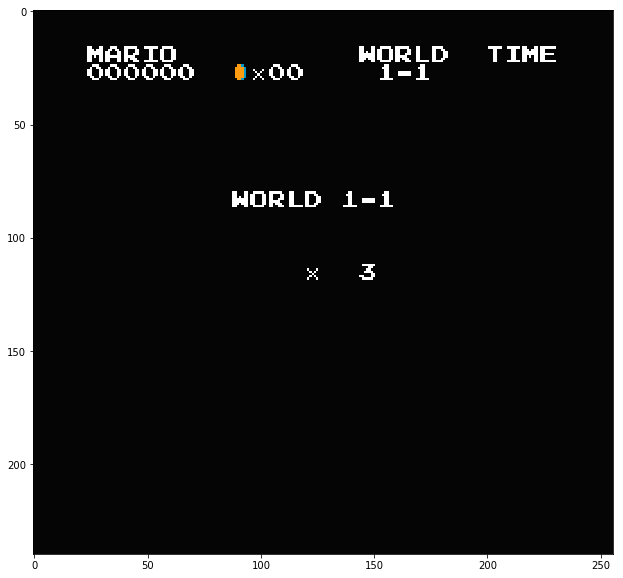

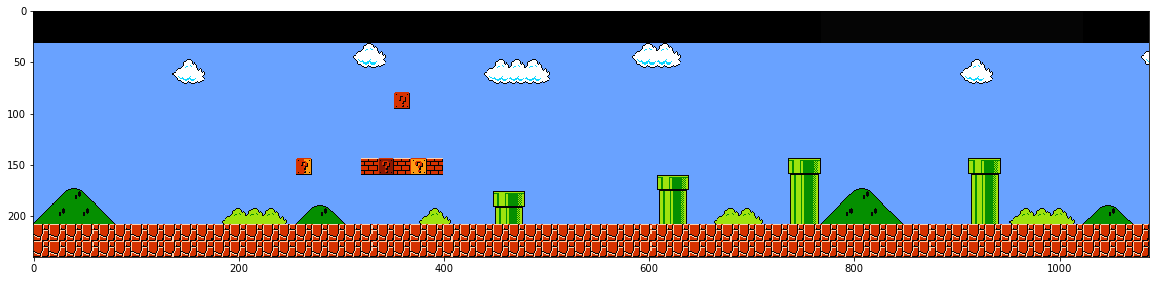

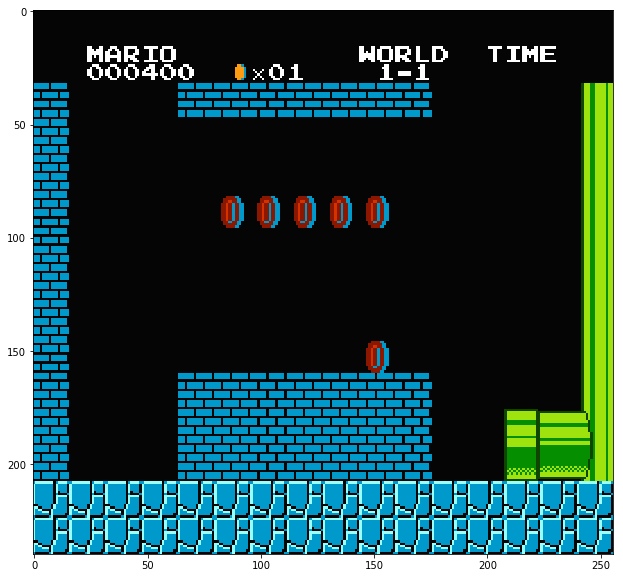

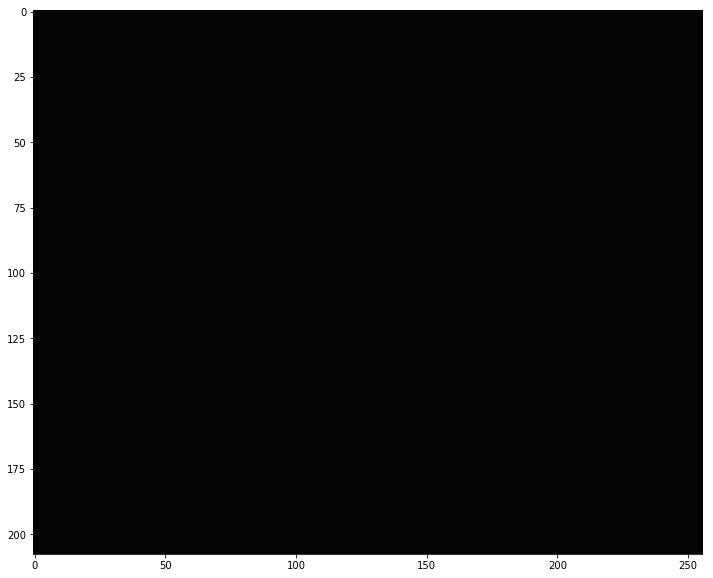

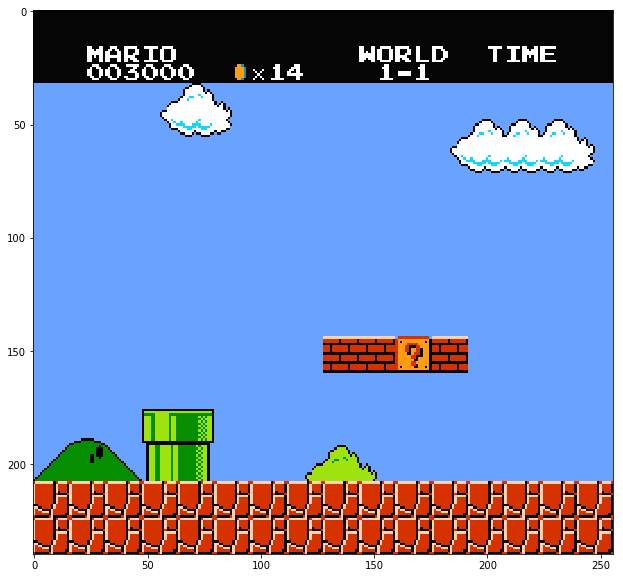

In [50]:
posx, posy = 0, 0
nt_total = {}
nt_totals = [nt_total]
tilex = 0
tiley = 0
interstitial = False
prev = None
curr = None
gap =30
big_gap = 60
timeSinceControl = 0
thresh = 0.5
accum = 0
screen_offsets = {}
room_v_time = {}
for t, (sx, sy) in sorted(ep_data["tilemap_motion"].items()):
    nt = ep_data["nametables"][t]
    attr = ep_data["attr"][t]
    pal = ep_data['palettes'][t]
    if sx >= 16:
        sx -= 32
    if sx <= -16:
        sx += 32
    if sy >= 15:
        sy -= 30
    if sy <= -15:
        sy += 30
    
    tilex += sx
    tiley += sy
    screen_offsets[t] = (tilex,tiley)
    if not ep_data['has_controls'][t]:
        timeSinceControl += 1
    else:
        timeSinceControl  = 0
    #print t, timeSinceControl
    if timeSinceControl > gap and ((sx != 0 or sy != 0) or timeSinceControl > big_gap):
        if not interstitial:
            #print t, timeSinceControl
            #plt.imshow(nt)
            #plt.show()
            pass
        interstitial = True
    #print t, timeSinceControl
    #print t, timeSinceControl,interstitial
    if  True:
        #print "t", t, "scroll by", sx, sy, tilex, tiley
        for x in range(0, 32):
            for y in range(0, scroll_area[3]):
                key = (y+tiley, x+tilex)
                if key not in nt_total:
                    nt_total[key] = {}
                nt_total[key][t] = (int(nt[y, x]),int(attr[y, x]),pal)
    prev = curr
    curr = {}
    diff = 0
    for x in range(0, 32):
        for y in range(0, 26):
            key = (y+tiley, x+tilex)
            if key not in curr:
                curr[key] = (int(nt[y, x]),int(attr[y, x]))
            if prev:
                if key not in prev:
                    diff += 1
                elif curr[key] != prev[key]:
                    diff += 1  
    if (diff > scroll_area[2]*scroll_area[3]*thresh) or (ep_data['has_controls'][t] and interstitial):
        print t,float(diff)/float(scroll_area[2]*scroll_area[3]) , 'REGAINED CONTROL'
        timeSinceControl  = 0
        interstitial = False
        #plt.imshow(nt)
        #plt.show()
        interstitial = False
        nt_total = {}
        nt_totals.append(nt_total)
    room_v_time[t] = len(nt_totals)-1
    
    
for nt_id,nt_total in enumerate(nt_totals):
    if len(nt_total) > 0:
        minx = min(map(lambda (y, x): x,nt_total.keys()))
        maxx = max(map(lambda (y, x): x,nt_total.keys()))+1
        miny = min(map(lambda (y, x): y,nt_total.keys()))
        maxy = max(map(lambda (y, x): y,nt_total.keys()))+1
        nt_result = {}
        for x in range(minx, maxx):
            for y in range(miny, maxy):
                if (y,x) in nt_total:
                    nt_result[y-miny, x-minx] = nt_total[(y, x)]
        colorized = ep_data["tile2colorized"]
        out_image = np.zeros(shape=((maxy-miny)*8, (maxx-minx)*8, 4))
        for x in range(0, maxx-minx):
            for y in range(0, maxy-miny):
                col = np.zeros(shape=(8,8,3))
                if (y,x) in nt_result:
                    ind = sorted(nt_result[y, x])
                    ind = ind[int(len(ind)/2)]

                    col = colorized[nt_result[y, x][ind]]
                out_image[y*8:(y+1)*8, x*8:(x+1)*8, :3] = col/255.
                out_image[y*8:(y+1)*8, x*8:(x+1)*8, 3] = 1.0
        plt.figure(figsize=(20,10)) 
        plt.imshow(out_image)
        plt.savefig('{}.png'.format(nt_id))
        plt.show()

In [ ]:
from unionfind import UnionFind

In [ ]:
def room2attr(room):
    
    minx = min(map(lambda (y, x): x,room.keys()))
    maxx = max(map(lambda (y, x): x,room.keys()))+1
    miny = min(map(lambda (y, x): y,room.keys()))
    maxy = max(map(lambda (y, x): y,room.keys()))+1
    attr_room = np.zeros((maxy-miny,maxx-minx,2))
    for x in range(minx, maxx):
        for y in range(miny, maxy):
            if (y,x) in room:
                ind = sorted(room[y, x])[0]
                attr_room[int(y-miny), int(x-minx),:] = np.array(room[(y, x)][ind][:-1])
    return attr_room
unions = UnionFind()

def dict_compare(d1, d2):
    d1_keys = set(d1.keys())
    d2_keys = set(d2.keys())
    intersect_keys = d1_keys.intersection(d2_keys)
    added = d1_keys - d2_keys
    removed = d2_keys - d1_keys
    modified = {o : (d1[o], d2[o]) for o in intersect_keys if d1[o] != d2[o]}
    same = set(o for o in intersect_keys if d1[o] == d2[o])
    return added, removed, modified, same

for room_id,room in enumerate(nt_totals):
    minx = min(map(lambda (y, x): x,room.keys()))
    maxx = max(map(lambda (y, x): x,room.keys()))+1
    miny = min(map(lambda (y, x): y,room.keys()))
    maxy = max(map(lambda (y, x): y,room.keys()))+1

    for other_id,other in enumerate(nt_totals):
        if len(room) > 0 and len(other) > 0:
            if room2attr(room).shape == room2attr(other).shape:
                if np.sum(np.abs(room2attr(room)-room2attr(other))) == 0:
                    unions.union(room_id,other_id)

            
cluster2room = {}

for u in unions:
    if unions[u] not in cluster2room:
        cluster2room[unions[u]] = set()
    cluster2room[unions[u]].add(u)
print 'digraph G{\n\trankdir=LR;\npenwidth=10;\n'

for cluster in cluster2room:
    print '\tsubgraph cluster_{} {{'.format(cluster)
    print '\t\tcolor=blue;'
    for room in cluster2room[cluster]:
        print '\t\t n{}[image="{}.png", label="{}", fontsize=240,fontcolor=red];'.format(room,room,room);
    print '\t}'
for ii in range(1,len(nt_totals)):
    print 'n{} -> n{} [penwidth=10];'.format(ii-1,ii)
print '}'

In [76]:
import tracking
reload(tracking)
tracks, old_tracks = tracking.tracks_from_sprite_data(ep_data['sprite_data'])
for track in tracks:
    old_tracks.append((track,tracks[track]))

0 16 11


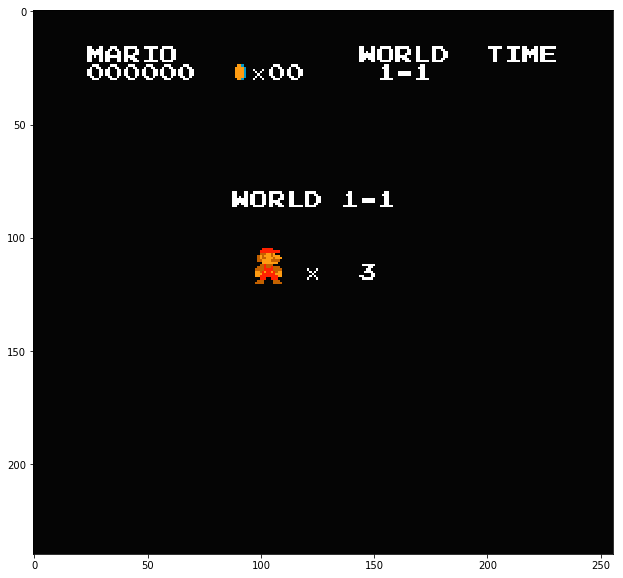

1 68 11


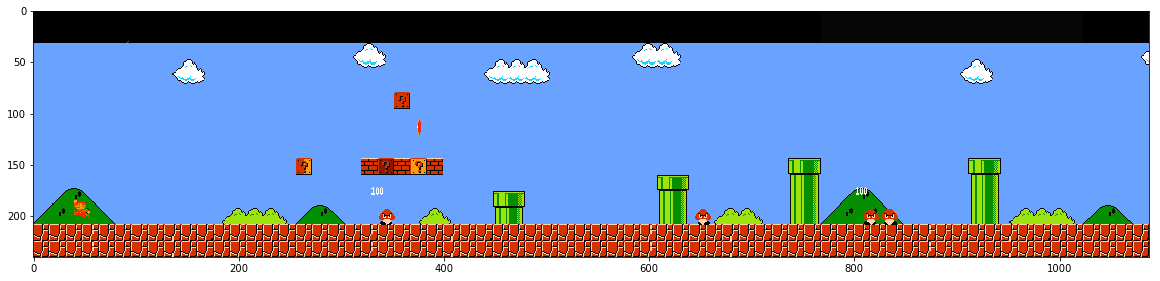

2 112 11


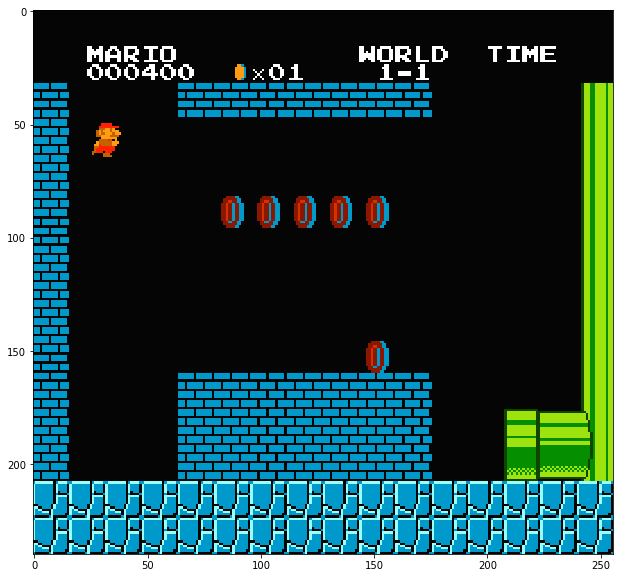

3 112 9


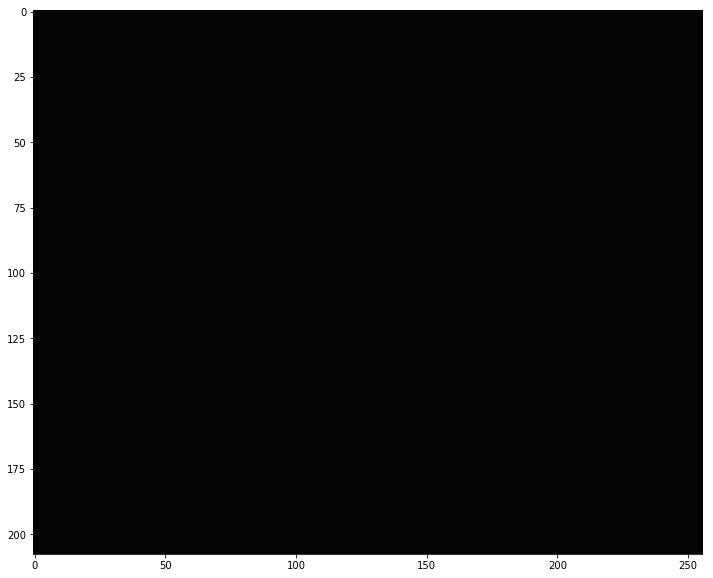

4 112 11


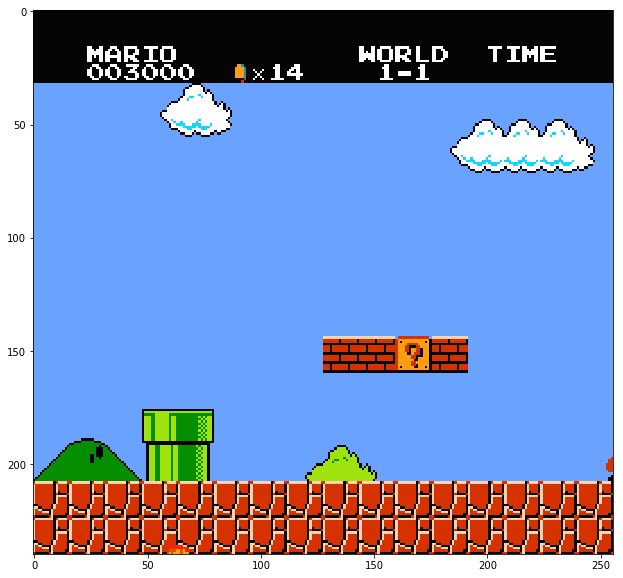

In [131]:
for room_id, nt_total in enumerate(nt_totals):
    minx = min(map(lambda (y, x): x,nt_total.keys()))
    maxx = max(map(lambda (y, x): x,nt_total.keys()))+1
    miny = min(map(lambda (y, x): y,nt_total.keys()))
    maxy = max(map(lambda (y, x): y,nt_total.keys()))+1
    print room_id, (minx+maxx)/2, (miny+maxy)/2
    nt_result = {}
    for x in range(minx, maxx):
        for y in range(miny, maxy):
            if (y,x) in nt_total:
                nt_result[y-miny, x-minx] = nt_total[(y, x)]
    colorized = ep_data["tile2colorized"]
    out_image = np.zeros(shape=((maxy-miny)*8, (maxx-minx)*8, 4))
    for x in range(0, maxx-minx):
        for y in range(0, maxy-miny):
            col = np.zeros(shape=(8,8,3))
            if (y,x) in nt_result:
                ind = sorted(nt_result[y, x])
                ind = ind[int(len(ind)/2)]

                col = colorized[nt_result[y, x][ind]]
            out_image[y*8:(y+1)*8, x*8:(x+1)*8, :3] = col/255.
            out_image[y*8:(y+1)*8, x*8:(x+1)*8, 3] = 1.0
    plt.figure(figsize=(20,10)) 
    #plt.imshow(out_image)
    
    for track in old_tracks:
        
        track_id = track[0]
        track = track[1]
        t0 = sorted(track)[4]
        if room_v_time[t0] == room_id:
            p0 = np.zeros(2)
            p0[0] = track[t0][0][0]
            p0[1] = track[t0][0][1]
            p0[0] += screen_offsets[t0][0]*8-(scroll_area[0]+minx)*8
            p0[1] += screen_offsets[t0][1]*8-(scroll_area[1]+miny)*8
            for sub_sprite in track[t0][2]:
                
                img = ep_data['id2colorized'][sub_sprite[0]]
                left = int(screen_offsets[t0][0]*8-(scroll_area[0]+minx)*8+sub_sprite[1][0])
                top =  int(screen_offsets[t0][1]*8-(scroll_area[1]+miny)*8+sub_sprite[1][1])
                for py in range(img.shape[0]):
                    for px in range(img.shape[1]):
                        if img[py,px,0] > 0 and py+top >= 0 and py+top < out_image.shape[0] and px+left >= 0 and px+left < out_image.shape[1]:
                            out_image[py+top,px+left,:-1] = img[py,px,:-1]/255.0
           
            #plt.plot(p0[0],240-p0[1],'ro')
    plt.imshow(out_image)
    plt.savefig("{}.png".format(room_id),bbox_inches='tight')
    plt.show()
    

In [79]:
print 

[[[   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [ 255.   34.    0.  255.]
  [ 255.   34.    0.  255.]
  [ 255.   34.    0.  255.]]

 [[   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [ 255.   34.    0.  255.]
  [ 255.   34.    0.  255.]
  [ 255.   34.    0.  255.]
  [ 255.   34.    0.  255.]]

 [[   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [ 196.   98.    0.  255.]
  [ 196.   98.    0.  255.]
  [ 196.   98.    0.  255.]
  [ 255.  156.   18.  255.]]

 [[   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [ 196.   98.    0.  255.]
  [ 255.  156.   18.  255.]
  [ 196.   98.    0.  255.]
  [ 255.  156.   18.  255.]
  [ 255.  156.   18.  255.]]

 [[   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [ 196.   9